In [1]:
!git clone https://github.com/claude9493/dsaa5002.git
!mv ./dsaa5002/dataset/ ./
!mv ./dsaa5002/utils/ ./

Cloning into 'dsaa5002'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 52 (delta 13), reused 6 (delta 1), pack-reused 0
Unpacking objects: 100% (52/52), done.


In [2]:
%%time

from utils.utils import create_dataset, Trainer
# from layer.layer import Embedding, FeaturesEmbedding, EmbeddingsInteraction, MultiLayerPerceptron

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Training on [{}].'.format(device))


Training on [cuda:0].
CPU times: user 1.04 s, sys: 750 ms, total: 1.79 s
Wall time: 6.32 s


In [3]:
%%time
SAMPLE_NUM = 10000
task = 'regression'  # 'classification'
dataset = create_dataset('movielens', sample_num=SAMPLE_NUM, task=task, device=device)
field_dims, (train_X, train_y), (valid_X, valid_y), (test_X, test_y) = dataset.train_valid_test_split()


CPU times: user 1.79 s, sys: 1.01 s, total: 2.8 s
Wall time: 16.4 s


In [4]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))


class MatrixFactorization(nn.Module):
    def __init__(self, field_dims, embed_dim=4):
        super(MatrixFactorization, self).__init__()
        n_users, n_movies = field_dims[0], field_dims[1]
        self.u = nn.Embedding(n_users, embed_dim)
        self.m = nn.Embedding(n_movies, embed_dim)
        self.u.weight.data.uniform_(0, 0.05)
        self.m.weight.data.uniform_(0, 0.05)

        
    def forward(self, x):
        users, movies = x[:,0], x[:,1]
        u, m = self.u(users), self.m(movies)
        return (u*m).sum(1).view(-1, 1)

Train loss: 0.080 | Validation loss 1.710:  18%|█▊        | 110/600 [00:06<00:28, 16.99it/s]


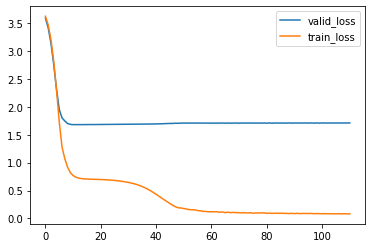

train_loss: 0.74133 | train_metric: -0.74133
valid_loss: 1.68118 | valid_metric: -1.68118
test_loss:  1.74792 | test_metric:  -1.74792
CPU times: user 6.52 s, sys: 239 ms, total: 6.76 s
Wall time: 7 s


In [5]:
%%time

EMBEDDING_DIM = 50
LEARNING_RATE = 0.005  # 1e-4
REGULARIZATION = 1e-6
BATCH_SIZE = 1024
EPOCH = 600
TRIAL = 100

cf = MatrixFactorization(field_dims, EMBEDDING_DIM).to(device)
optimizer = optim.Adam(cf.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
# criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
criterion = RMSELoss()

trainer = Trainer(cf, optimizer, criterion, BATCH_SIZE, task=task)
trainer.train(train_X, train_y, epoch=EPOCH, trials=TRIAL, valid_X=valid_X, valid_y=valid_y)
test_loss, test_metric = trainer.test(test_X, test_y)
print('test_loss:  {:.5f} | test_metric:  {:.5f}'.format(test_loss, test_metric))
